In [920]:
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

In [921]:
experiment_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /'
output_dir = 'datasink_test'
working_dir = 'workingdir_test'

# list of subject identifiers (remember we use only right handed subjects)
#subject_list = ['sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-09', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29']
subject_list = ['sub-03']

# task name
#task_name = "fingerfootlips"

# Smoothing widths used during preprocessing
fwhm = [4]

# Template to normalize to
template = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

In [922]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

In [923]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj('/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/firstlevel/output_firstlevel_pmod/contrasts/',
                        '_subject_id_{subject_id}', 'con_0001.nii'),
             'transform': opj('/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/antsreg/registrationtemp/output_dir/registrationtemp/_subject_id_sub-03/transformComposite.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [924]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

211112-22:37:38,828 nipype.workflow INFO:
	 Generated workflow graph: /media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /workingdir_test/antsflow/graph.png (graph2use=colored, simple_form=True).


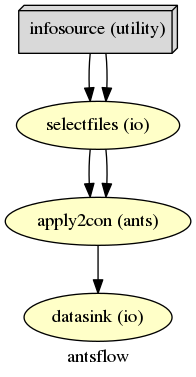

In [925]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.png'))

In [926]:
antsflow.run('MultiProc', plugin_args={'n_procs': 8})

211112-22:37:38,841 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
211112-22:37:38,855 nipype.workflow INFO:
	 Running in parallel.
211112-22:37:38,859 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 8/8.
211112-22:37:40,132 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /workingdir_test/antsflow/_fwhm_id_4_subject_id_sub-03/selectfiles".
211112-22:37:40,139 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211112-22:37:40,151 nipype.workflow INFO:
	 [Node] Finished "antsflow.selectfiles".
211112-22:37:40,860 nipype.workflow INFO:
	 [Job 0] Completed (antsflow.selectfiles).
211112-22:37:40,863 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 8/8.


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


211112-22:37:42,184 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.apply2con" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /workingdir_test/antsflow/_fwhm_id_4_subject_id_sub-03/apply2con".
211112-22:37:42,196 nipype.workflow INFO:
	 [Node] Setting-up "_apply2con0" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /workingdir_test/antsflow/_fwhm_id_4_subject_id_sub-03/apply2con/mapflow/_apply2con0".
211112-22:37:42,204 nipype.workflow INFO:
	 [Node] Running "_apply2con0" ("nipype.interfaces.ants.resampling.ApplyTransforms"), a CommandLine Interface with command:
antsApplyTransforms --float --default-value 0 --float 0 --input /media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/firstlevel/output_firstlevel_pmod/contrasts/_subject_id_sub-03/con_0001.nii --input-image-type 3 --interpolation BSpline --output con_0001_trans.nii --reference-image /media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/fmriprep/mni_icbm152_nlin_asym

In [938]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

In [935]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg_1mm = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

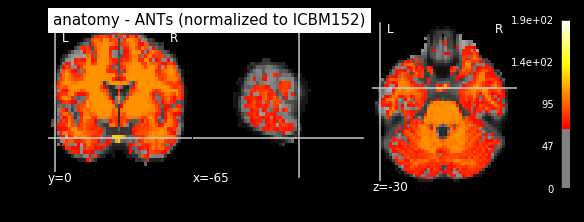

In [929]:
#template 1mm mni152_asym
plot_stat_map(
   '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/antsreg/output_dir/registrationtemp/_subject_id_sub-04/transform_Warped.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=70, display_mode='ortho', cut_coords=(-65, 0, -30));

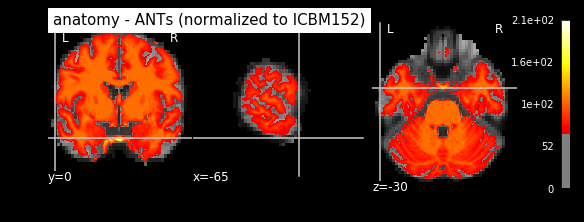

In [930]:
#template mni_icbm152_t1_tal_nlin_asym_09c_brain
plot_stat_map(
   '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/antsreg/registrationtemp/output_dir/registrationtemp/_subject_id_sub-03/transform_Warped.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=70, display_mode='ortho', cut_coords=(-65, 0, -30));

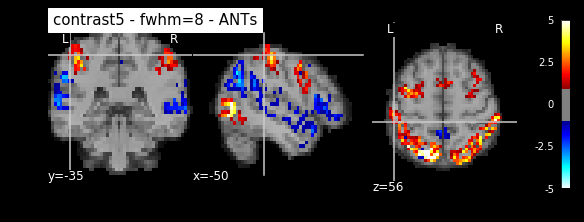

In [939]:
plot_stat_map(
    '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /datasink/norm_ants/sub-sub-03_fwhm4/con_0001_trans.nii', title='contrast5 - fwhm=8 - ANTs',
    bg_img=anatimg, threshold=1, vmax=5, display_mode='ortho', cut_coords=(-50, -35, 56));

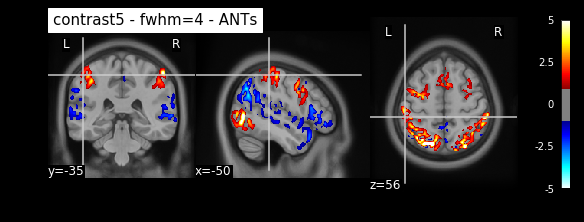

In [936]:
plot_stat_map(
    '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /datasink_test/norm_ants/sub-sub-03_fwhm4/con_0001_trans.nii', title='contrast5 - fwhm=4 - ANTs',
    bg_img=anatimg_1mm, threshold=1, vmax=5, display_mode='ortho', cut_coords=(-50, -35, 56));

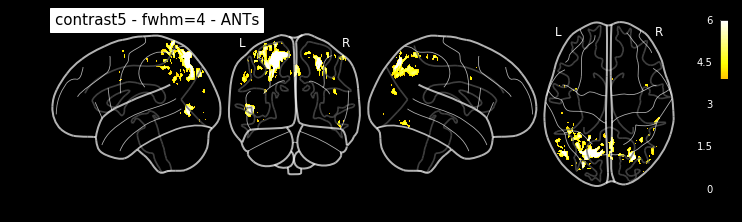

In [937]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /datasink_test/norm_ants/sub-sub-03_fwhm4/con_0001_trans.nii', colorbar=True,
    threshold=4, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=4 - ANTs')


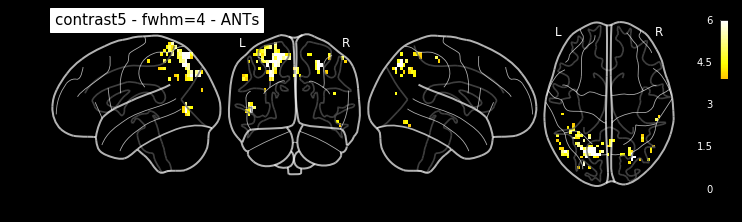

In [940]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /datasink/norm_ants/sub-sub-03_fwhm4/con_0001_trans.nii', colorbar=True,
    threshold=4, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=4 - ANTs')


In [934]:
#from nilearn import plotting

#plotting.plot_glass_brain('/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/normalization /datasink/norm_ants/sub-sub-01_fwhm4/con_0001_trans.nii', threshold=2, colorbar=True,
#                          plot_abs=False)